# Parametric study on the dimension of the latent space

In [24]:
import os 
import librosa
import librosa.display
import soundfile as sf
import pandas as pd

import tensorflow as tf

from scipy import signal
import matplotlib.pyplot as plt

import sklearn
from sklearn import metrics
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
import tensorflow_probability as tfp
from tensorflow.keras import backend as K
import numpy as np
## import functions
import sys
sys.path.append("..")
from src import Train_test_sets_maker
from src import MinMaxNormalisation
from src import Visualize
from src import MIMII_AE

In [38]:
def import_data(wav_name,channel=4):
    try:
        multi_channel_data, sr = sf.read(wav_name)
        if multi_channel_data.ndim <= 1:
            # ADD HERE A CONDITION TO READ MULTICHANNEL LENGTH AND REMOVE IF TOO SHORT
            return sr, multi_channel_data
        return sr, np.array(multi_channel_data)[:,channel]
    except ValueError:
        pass

def PSD_DF_Maker(user_path,data_path):
    your_path = user_path+data_path
    files = os.listdir(your_path)
    
    PSD_list = [] 
    
    for index,file in enumerate(files):
        if os.path.isfile(os.path.join(your_path,file)):

            fs, audio = import_data(os.path.join(your_path,file))
            f_vec, PSD = signal.welch(audio, fs, nperseg=1024)
            PSD = PSD[f_vec < 3000]

            PSD_list.append(PSD)
    return pd.DataFrame(PSD_list)

def lossCalcMSE(model,data):
    reconstructions = model(tf.cast(data,float))
    return tf.keras.losses.mse(reconstructions,data)

#lossValues = lossCalcMSE(autoencoder, test_set)

In [39]:
### Path files
names = ['fan']
stati = ['normal', 'abnormal']
SNR = ['+6dB', '-6dB']

folder = '/MIMII/RawData/' + SNR[0] + '/' # fan/id_00/abnormal'
user_path = 'C:/Users/carbo/Documents/'
writer_path = 'C:/Users/carbo/Documents/MIMII/Data/' + SNR[0] +'/PSD/'

### Parameters
#IDs = ['id_00','id_02', 'id_04', 'id_06']

IDs = ['id_00']

AUCs = []

latent_space = []

for ID in IDs:

    # Get data
    #ID = IDs[2]
    status = stati[0] # normal
    name = names[0]
    data_path = folder + name + '/' + ID + '/' + status
    df_PSD_normal = PSD_DF_Maker(user_path, data_path)

    status = stati[1] # abnormal
    data_path = folder + name + '/' + ID + '/' + status
    df_PSD_abnormal = PSD_DF_Maker(user_path, data_path)

    # Create datasets for training/evaluation
    train_set, test_set, test_labels = Train_test_sets_maker.fun(df_PSD_normal,df_PSD_abnormal)
    # Normalize
    MIN,MAX = MinMaxNormalisation.getMinMax(train_set)
    train_set = MinMaxNormalisation.fun(train_set,MIN,MAX)
    test_set = MinMaxNormalisation.fun(test_set,MIN,MAX)


    # Train algorithm
    autoencoder = MIMII_AE.fun(train_set.shape[1])
    history = autoencoder.fit(train_set, train_set, 
                              epochs=50, 
                              batch_size=512,
                              validation_data=(test_set,test_set),
                              validation_split = 0.1,
                              verbose = 1,
                              shuffle=True
                             )
    
    lossValues = lossCalcMSE(autoencoder, test_set)
    AUCs.append(metrics.roc_auc_score(~test_labels, lossValues))      

Train & test sets created !
Epoch 1/50
2/2 [==============================] - 1s 179ms/step - loss: 0.0028 - val_loss: 0.0203
Epoch 2/50
2/2 [==============================] - 0s 25ms/step - loss: 0.0027 - val_loss: 0.0200
Epoch 3/50
2/2 [==============================] - 0s 28ms/step - loss: 0.0026 - val_loss: 0.0197
Epoch 4/50
2/2 [==============================] - 0s 27ms/step - loss: 0.0025 - val_loss: 0.0193
Epoch 5/50
2/2 [==============================] - 0s 29ms/step - loss: 0.0023 - val_loss: 0.0189
Epoch 6/50
2/2 [==============================] - 0s 32ms/step - loss: 0.0022 - val_loss: 0.0184
Epoch 7/50
2/2 [==============================] - 0s 32ms/step - loss: 0.0020 - val_loss: 0.0178
Epoch 8/50
2/2 [==============================] - 0s 30ms/step - loss: 0.0019 - val_loss: 0.0172
Epoch 9/50
2/2 [==============================] - 0s 32ms/step - loss: 0.0017 - val_loss: 0.0164
Epoch 10/50
2/2 [==============================] - 0s 29ms/step - loss: 0.0015 - val_loss: 0.0156


## Latent space parametrisation

In [41]:
train_set.head()

,0,1,2,3,4,5,6,7,8,9,...,182,183,184,185,186,187,188,189,190,191
0,0.007807,0.030539,0.034418,0.083895,0.497701,0.304752,0.020914,0.027205,0.130414,0.180463,...,0.000333,0.000333,0.000365,0.000366,0.000440,0.000360,0.000313,0.000320,0.000336,0.000373
1,0.008302,0.037215,0.036163,0.082343,0.464568,0.289044,0.025346,0.023648,0.101207,0.146460,...,0.000353,0.000290,0.000251,0.000296,0.000288,0.000343,0.000312,0.000337,0.000352,0.000348
2,0.015148,0.070005,0.069551,0.124495,0.597622,0.345013,0.034348,0.038554,0.128566,0.163284,...,0.000568,0.000537,0.000480,0.000435,0.000457,0.000405,0.000507,0.000664,0.000654,0.000562
3,0.013738,0.070504,0.062392,0.069128,0.281326,0.160750,0.023840,0.061850,0.182800,0.172611,...,0.000660,0.000708,0.000781,0.000830,0.000896,0.001027,0.001334,0.001434,0.001250,0.001096
8,0.015891,0.083021,0.088098,0.104561,0.389981,0.217808,0.039632,0.047825,0.155283,0.188809,...,0.000511,0.000501,0.000449,0.000471,0.000360,0.000347,0.000383,0.000442,0.000391,0.000448


In [40]:
test_set.iloc[0,:]

0      0.052693
1      0.303920
2      0.242283
3      0.114076
4      0.457656
         ...   
187    0.000300
188    0.000325
189    0.000276
190    0.000308
191    0.000286
Name: 353, Length: 192, dtype: float64

In [63]:
tf_test_set = tf.cast(test_set,float)

In [64]:
tf_test_set

<tf.Tensor: shape=(814, 192), dtype=float32, numpy=
array([[ 5.26929460e-02,  3.03919822e-01,  2.42283031e-01, ...,
         2.76168867e-04,  3.07867624e-04,  2.85802031e-04],
       [ 1.72184706e-02,  8.14054832e-02,  7.14851767e-02, ...,
         2.35127212e-04,  3.01935623e-04,  3.31047195e-04],
       [ 1.99281219e-02,  9.66267586e-02,  9.23989788e-02, ...,
         4.10531793e-04,  4.82653530e-04,  3.36285913e-04],
       ...,
       [ 3.00001334e-02,  1.24714255e-01,  9.30833742e-02, ...,
        -2.84275186e-04, -2.77282757e-04, -2.67536321e-04],
       [ 1.89008527e-02,  9.48643237e-02,  8.13147426e-02, ...,
         2.10503989e-04,  1.51107582e-04,  1.45503378e-04],
       [ 3.37217227e-02,  1.40131533e-01,  1.32102847e-01, ...,
         1.60857293e-04,  1.29621010e-04,  1.77739377e-04]], dtype=float32)>

In [65]:
encoded_data = autoencoder.encoder(tf_test_set,192).numpy()

In [69]:
encoded_data[0,:]

array([0.08315315, 0.        , 0.        , 0.        , 0.        ,
       0.5140048 , 0.21146734, 0.        ], dtype=float32)

In [71]:
encoded_data[1,:]

array([0.07081422, 0.        , 0.        , 0.        , 0.        ,
       0.6009894 , 0.21250372, 0.        ], dtype=float32)

## Latent space visualization

It seems only 3 features actually contribute to the representation of the data in the latent space

<function matplotlib.pyplot.show(close=None, block=None)>

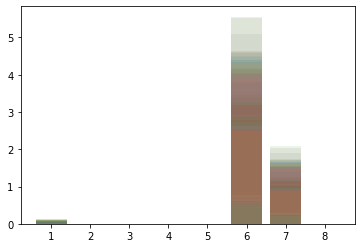

In [75]:
feature_name = ['1','2','3','4','5','6','7','8']
for data in encoded_data:
    plt.bar(feature_name, data, alpha=0.1)
plt.show

## Relearning using only 3 features in latent space 

In [77]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import layers, losses

class AnomalyDetector(Model):
    
  def __init__(self,InputSize):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Dense(64, activation="relu"),
      layers.Dense(64, activation="relu"),
      layers.Dense(3, activation="relu"),
    ])
    

    self.decoder = tf.keras.Sequential([
      layers.Dense(64, activation="relu"),
      layers.Dense(64, activation="relu"),
      layers.Dense(InputSize, activation="linear")])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

def fun(InputSize, loss_fun = "mse"):
    
    AE =  AnomalyDetector(InputSize)
    AE.compile(loss=loss_fun,
               optimizer='adam'
              )
    return AE

In [79]:
### Path files
names = ['fan']
stati = ['normal', 'abnormal']
SNR = ['+6dB', '-6dB']

folder = '/MIMII/RawData/' + SNR[0] + '/' # fan/id_00/abnormal'
user_path = 'C:/Users/carbo/Documents/'
writer_path = 'C:/Users/carbo/Documents/MIMII/Data/' + SNR[0] +'/PSD/'

### Parameters
#IDs = ['id_00','id_02', 'id_04', 'id_06']

IDs = ['id_00']

AUCs = []

latent_space = []

for ID in IDs:

    # Get data
    #ID = IDs[2]
    status = stati[0] # normal
    name = names[0]
    data_path = folder + name + '/' + ID + '/' + status
    df_PSD_normal = PSD_DF_Maker(user_path, data_path)

    status = stati[1] # abnormal
    data_path = folder + name + '/' + ID + '/' + status
    df_PSD_abnormal = PSD_DF_Maker(user_path, data_path)

    # Create datasets for training/evaluation
    train_set, test_set, test_labels = Train_test_sets_maker.fun(df_PSD_normal,df_PSD_abnormal)
    # Normalize
    MIN,MAX = MinMaxNormalisation.getMinMax(train_set)
    train_set = MinMaxNormalisation.fun(train_set,MIN,MAX)
    test_set = MinMaxNormalisation.fun(test_set,MIN,MAX)


    # Train algorithm
    autoencoder = fun(train_set.shape[1])
    history = autoencoder.fit(train_set, train_set, 
                              epochs=50, 
                              batch_size=512,
                              validation_data=(test_set,test_set),
                              validation_split = 0.1,
                              verbose = 1,
                              shuffle=True
                             )
    
    lossValues = lossCalcMSE(autoencoder, test_set)
    AUCs.append(metrics.roc_auc_score(~test_labels, lossValues))      

Train & test sets created !
Epoch 1/50
2/2 [==============================] - 1s 153ms/step - loss: 0.0028 - val_loss: 0.0204
Epoch 2/50
2/2 [==============================] - 0s 27ms/step - loss: 0.0027 - val_loss: 0.0202
Epoch 3/50
2/2 [==============================] - 0s 28ms/step - loss: 0.0026 - val_loss: 0.0200
Epoch 4/50
2/2 [==============================] - 0s 25ms/step - loss: 0.0025 - val_loss: 0.0197
Epoch 5/50
2/2 [==============================] - 0s 23ms/step - loss: 0.0024 - val_loss: 0.0194
Epoch 6/50
2/2 [==============================] - 0s 24ms/step - loss: 0.0023 - val_loss: 0.0191
Epoch 7/50
2/2 [==============================] - 0s 25ms/step - loss: 0.0021 - val_loss: 0.0187
Epoch 8/50
2/2 [==============================] - 0s 24ms/step - loss: 0.0020 - val_loss: 0.0182
Epoch 9/50
2/2 [==============================] - 0s 23ms/step - loss: 0.0019 - val_loss: 0.0176
Epoch 10/50
2/2 [==============================] - 0s 22ms/step - loss: 0.0017 - val_loss: 0.0169


In [80]:
AUCs

[0.9452577437835423]

<function matplotlib.pyplot.show(close=None, block=None)>

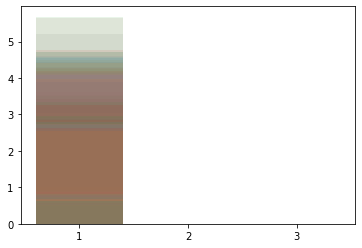

In [82]:
tf_test_set = tf.cast(test_set,float)
encoded_data = autoencoder.encoder(tf_test_set,192).numpy()
feature_name = ['1','2','3']
for data in encoded_data:
    plt.bar(feature_name, data, alpha=0.1)
plt.show

Only 1 feature in the latent space is enough ? Let's see that !

Train & test sets created !
Epoch 1/50
2/2 [==============================] - 1s 159ms/step - loss: 0.0035 - val_loss: 0.0252
Epoch 2/50
2/2 [==============================] - 0s 23ms/step - loss: 0.0034 - val_loss: 0.0251
Epoch 3/50
2/2 [==============================] - 0s 23ms/step - loss: 0.0033 - val_loss: 0.0249
Epoch 4/50
2/2 [==============================] - 0s 24ms/step - loss: 0.0032 - val_loss: 0.0247
Epoch 5/50
2/2 [==============================] - 0s 23ms/step - loss: 0.0031 - val_loss: 0.0245
Epoch 6/50
2/2 [==============================] - 0s 26ms/step - loss: 0.0030 - val_loss: 0.0243
Epoch 7/50
2/2 [==============================] - 0s 25ms/step - loss: 0.0029 - val_loss: 0.0240
Epoch 8/50
2/2 [==============================] - 0s 22ms/step - loss: 0.0027 - val_loss: 0.0238
Epoch 9/50
2/2 [==============================] - 0s 23ms/step - loss: 0.0026 - val_loss: 0.0234
Epoch 10/50
2/2 [==============================] - 0s 23ms/step - loss: 0.0025 - val_loss: 0.0231


<function matplotlib.pyplot.show(close=None, block=None)>

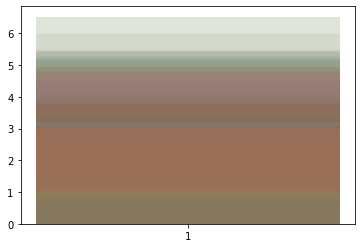

In [93]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import layers, losses

class AnomalyDetector(Model):
    
  def __init__(self,InputSize):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Dense(64, activation="relu"),
      layers.Dense(64, activation="relu"),
      layers.Dense(8, activation= "relu"),
      layers.Dense(8, activation = "relu"),
      layers.Dense(1, activation="relu"),
    ])
    

    self.decoder = tf.keras.Sequential([
      layers.Dense(8, activation= "relu"),
      layers.Dense(8, activation= "relu"),
      layers.Dense(64, activation="relu"),
      layers.Dense(64, activation="relu"),
      layers.Dense(InputSize, activation="linear")])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

def fun(InputSize, loss_fun = "mse"):
    
    AE =  AnomalyDetector(InputSize)
    AE.compile(loss=loss_fun,
               optimizer='adam'
              )
    return AE

### Path files
names = ['fan']
stati = ['normal', 'abnormal']
SNR = ['+6dB', '-6dB']

folder = '/MIMII/RawData/' + SNR[0] + '/' # fan/id_00/abnormal'
user_path = 'C:/Users/carbo/Documents/'
writer_path = 'C:/Users/carbo/Documents/MIMII/Data/' + SNR[0] +'/PSD/'

### Parameters
#IDs = ['id_00','id_02', 'id_04', 'id_06']

IDs = ['id_00']

AUCs = []

latent_space = []

for ID in IDs:

    # Get data
    #ID = IDs[2]
    status = stati[0] # normal
    name = names[0]
    data_path = folder + name + '/' + ID + '/' + status
    df_PSD_normal = PSD_DF_Maker(user_path, data_path)

    status = stati[1] # abnormal
    data_path = folder + name + '/' + ID + '/' + status
    df_PSD_abnormal = PSD_DF_Maker(user_path, data_path)

    # Create datasets for training/evaluation
    train_set, test_set, test_labels = Train_test_sets_maker.fun(df_PSD_normal,df_PSD_abnormal)
    # Normalize
    MIN,MAX = MinMaxNormalisation.getMinMax(train_set)
    train_set = MinMaxNormalisation.fun(train_set,MIN,MAX)
    test_set = MinMaxNormalisation.fun(test_set,MIN,MAX)


    # Train algorithm
    autoencoder = fun(train_set.shape[1])
    history = autoencoder.fit(train_set, train_set, 
                              epochs=50, 
                              batch_size=512,
                              validation_data=(test_set,test_set),
                              validation_split = 0.1,
                              verbose = 1,
                              shuffle=True
                             )
    
    lossValues = lossCalcMSE(autoencoder, test_set)
    AUCs.append(metrics.roc_auc_score(~test_labels, lossValues))      
    
tf_test_set = tf.cast(test_set,float)
encoded_data = autoencoder.encoder(tf_test_set,192).numpy()
feature_name = ['1']
for data in encoded_data:
    plt.bar(feature_name, data, alpha=0.1)
plt.show

In [94]:
AUCs

[0.9522363551847581]

Let's see if the structure that has been shown here can be used to have 3 features that are non-zero and if that increases the AUCs

Train & test sets created !
Epoch 1/50
2/2 [==============================] - 1s 147ms/step - loss: 0.0035 - val_loss: 0.0259
Epoch 2/50
2/2 [==============================] - 0s 26ms/step - loss: 0.0035 - val_loss: 0.0257
Epoch 3/50
2/2 [==============================] - 0s 25ms/step - loss: 0.0034 - val_loss: 0.0255
Epoch 4/50
2/2 [==============================] - 0s 24ms/step - loss: 0.0032 - val_loss: 0.0253
Epoch 5/50
2/2 [==============================] - 0s 23ms/step - loss: 0.0031 - val_loss: 0.0251
Epoch 6/50
2/2 [==============================] - 0s 27ms/step - loss: 0.0030 - val_loss: 0.0248
Epoch 7/50
2/2 [==============================] - 0s 25ms/step - loss: 0.0029 - val_loss: 0.0245
Epoch 8/50
2/2 [==============================] - 0s 26ms/step - loss: 0.0028 - val_loss: 0.0241
Epoch 9/50
2/2 [==============================] - 0s 24ms/step - loss: 0.0026 - val_loss: 0.0237
Epoch 10/50
2/2 [==============================] - 0s 23ms/step - loss: 0.0024 - val_loss: 0.0231


<function matplotlib.pyplot.show(close=None, block=None)>

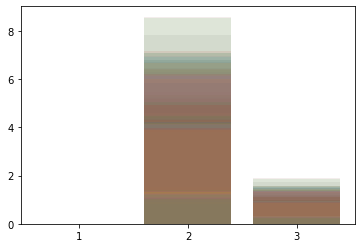

In [96]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import layers, losses

class AnomalyDetector(Model):
    
  def __init__(self,InputSize):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Dense(64, activation="relu"),
      layers.Dense(64, activation="relu"),
      layers.Dense(8, activation= "relu"),
      layers.Dense(8, activation = "relu"),
      layers.Dense(3, activation="relu"),
    ])
    

    self.decoder = tf.keras.Sequential([
      layers.Dense(8, activation= "relu"),
      layers.Dense(8, activation= "relu"),
      layers.Dense(64, activation="relu"),
      layers.Dense(64, activation="relu"),
      layers.Dense(InputSize, activation="linear")])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

def fun(InputSize, loss_fun = "mse"):
    
    AE =  AnomalyDetector(InputSize)
    AE.compile(loss=loss_fun,
               optimizer='adam'
              )
    return AE

### Path files
names = ['fan']
stati = ['normal', 'abnormal']
SNR = ['+6dB', '-6dB']

folder = '/MIMII/RawData/' + SNR[0] + '/' # fan/id_00/abnormal'
user_path = 'C:/Users/carbo/Documents/'
writer_path = 'C:/Users/carbo/Documents/MIMII/Data/' + SNR[0] +'/PSD/'

### Parameters
#IDs = ['id_00','id_02', 'id_04', 'id_06']

IDs = ['id_00']

AUCs = []

latent_space = []

for ID in IDs:

    # Get data
    #ID = IDs[2]
    status = stati[0] # normal
    name = names[0]
    data_path = folder + name + '/' + ID + '/' + status
    df_PSD_normal = PSD_DF_Maker(user_path, data_path)

    status = stati[1] # abnormal
    data_path = folder + name + '/' + ID + '/' + status
    df_PSD_abnormal = PSD_DF_Maker(user_path, data_path)

    # Create datasets for training/evaluation
    train_set, test_set, test_labels = Train_test_sets_maker.fun(df_PSD_normal,df_PSD_abnormal)
    # Normalize
    MIN,MAX = MinMaxNormalisation.getMinMax(train_set)
    train_set = MinMaxNormalisation.fun(train_set,MIN,MAX)
    test_set = MinMaxNormalisation.fun(test_set,MIN,MAX)


    # Train algorithm
    autoencoder = fun(train_set.shape[1])
    history = autoencoder.fit(train_set, train_set, 
                              epochs=50, 
                              batch_size=512,
                              validation_data=(test_set,test_set),
                              validation_split = 0.1,
                              verbose = 1,
                              shuffle=True
                             )
    
    lossValues = lossCalcMSE(autoencoder, test_set)
    AUCs.append(metrics.roc_auc_score(~test_labels, lossValues))      
    
tf_test_set = tf.cast(test_set,float)
encoded_data = autoencoder.encoder(tf_test_set,192).numpy()
feature_name = ['1','2','3']
for data in encoded_data:
    plt.bar(feature_name, data, alpha=0.1)
plt.show

In [98]:
AUCs

[0.9407180242561077]

## It seems it is better to have fewer latent space dimension if possible. The AUCs appears greater.

What is the network gets progressively shorter :  128,64,32,16,8,2,1 and reverse ?

Train & test sets created !
Epoch 1/50
2/2 [==============================] - 1s 188ms/step - loss: 0.0035 - val_loss: 0.0253
Epoch 2/50
2/2 [==============================] - 0s 24ms/step - loss: 0.0034 - val_loss: 0.0252
Epoch 3/50
2/2 [==============================] - 0s 23ms/step - loss: 0.0034 - val_loss: 0.0252
Epoch 4/50
2/2 [==============================] - 0s 26ms/step - loss: 0.0033 - val_loss: 0.0251
Epoch 5/50
2/2 [==============================] - 0s 27ms/step - loss: 0.0033 - val_loss: 0.0250
Epoch 6/50
2/2 [==============================] - 0s 26ms/step - loss: 0.0032 - val_loss: 0.0250
Epoch 7/50
2/2 [==============================] - 0s 27ms/step - loss: 0.0032 - val_loss: 0.0249
Epoch 8/50
2/2 [==============================] - 0s 26ms/step - loss: 0.0031 - val_loss: 0.0248
Epoch 9/50
2/2 [==============================] - 0s 27ms/step - loss: 0.0031 - val_loss: 0.0248
Epoch 10/50
2/2 [==============================] - 0s 28ms/step - loss: 0.0030 - val_loss: 0.0247


<function matplotlib.pyplot.show(close=None, block=None)>

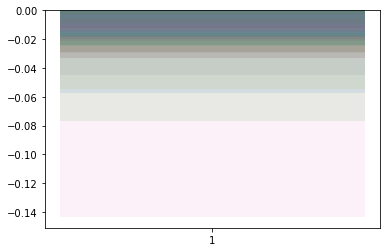

In [100]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import layers, losses

class AnomalyDetector(Model):
    
  def __init__(self,InputSize):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Dense(128, activation="relu"),
      layers.Dense(64, activation="relu"),
      layers.Dense(32, activation="relu"),
      layers.Dense(16, activation= "relu"),
      layers.Dense(8, activation = "relu"),
      layers.Dense(4, activation="relu"),
      layers.Dense(2, activation="relu"),
      layers.Dense(1, activation="selu"),
    ])
    

    self.decoder = tf.keras.Sequential([
      layers.Dense(2, activation= "relu"),
      layers.Dense(4, activation= "relu"),
      layers.Dense(8, activation="relu"),
      layers.Dense(16, activation="relu"),
      layers.Dense(32, activation="relu"),
      layers.Dense(64, activation="relu"),
      layers.Dense(128, activation="relu"),
      layers.Dense(InputSize, activation="linear")])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

def fun(InputSize, loss_fun = "mse"):
    
    AE =  AnomalyDetector(InputSize)
    AE.compile(loss=loss_fun,
               optimizer='adam'
              )
    return AE

### Path files
names = ['fan']
stati = ['normal', 'abnormal']
SNR = ['+6dB', '-6dB']

folder = '/MIMII/RawData/' + SNR[0] + '/' # fan/id_00/abnormal'
user_path = 'C:/Users/carbo/Documents/'
writer_path = 'C:/Users/carbo/Documents/MIMII/Data/' + SNR[0] +'/PSD/'

### Parameters
#IDs = ['id_00','id_02', 'id_04', 'id_06']

IDs = ['id_00']

AUCs = []

latent_space = []

for ID in IDs:

    # Get data
    #ID = IDs[2]
    status = stati[0] # normal
    name = names[0]
    data_path = folder + name + '/' + ID + '/' + status
    df_PSD_normal = PSD_DF_Maker(user_path, data_path)

    status = stati[1] # abnormal
    data_path = folder + name + '/' + ID + '/' + status
    df_PSD_abnormal = PSD_DF_Maker(user_path, data_path)

    # Create datasets for training/evaluation
    train_set, test_set, test_labels = Train_test_sets_maker.fun(df_PSD_normal,df_PSD_abnormal)
    # Normalize
    MIN,MAX = MinMaxNormalisation.getMinMax(train_set)
    train_set = MinMaxNormalisation.fun(train_set,MIN,MAX)
    test_set = MinMaxNormalisation.fun(test_set,MIN,MAX)


    # Train algorithm
    autoencoder = fun(train_set.shape[1])
    history = autoencoder.fit(train_set, train_set, 
                              epochs=50, 
                              batch_size=512,
                              validation_data=(test_set,test_set),
                              validation_split = 0.1,
                              verbose = 1,
                              shuffle=True
                             )
    
    lossValues = lossCalcMSE(autoencoder, test_set)
    AUCs.append(metrics.roc_auc_score(~test_labels, lossValues))      
    
tf_test_set = tf.cast(test_set,float)
encoded_data = autoencoder.encoder(tf_test_set,192).numpy()
feature_name = ['1']
for data in encoded_data:
    plt.bar(feature_name, data, alpha=0.1)
plt.show

Si l'autoencoder est trop large avec juste du ReLu, les données se "perdent" et on a plus de quoi faire la prédiction. 

Train & test sets created !
Epoch 1/50
2/2 [==============================] - 1s 149ms/step - loss: 0.0035 - val_loss: 0.0252
Epoch 2/50
2/2 [==============================] - 0s 25ms/step - loss: 0.0033 - val_loss: 0.0250
Epoch 3/50
2/2 [==============================] - 0s 23ms/step - loss: 0.0032 - val_loss: 0.0248
Epoch 4/50
2/2 [==============================] - 0s 23ms/step - loss: 0.0031 - val_loss: 0.0246
Epoch 5/50
2/2 [==============================] - 0s 24ms/step - loss: 0.0030 - val_loss: 0.0244
Epoch 6/50
2/2 [==============================] - 0s 24ms/step - loss: 0.0029 - val_loss: 0.0241
Epoch 7/50
2/2 [==============================] - 0s 22ms/step - loss: 0.0027 - val_loss: 0.0238
Epoch 8/50
2/2 [==============================] - 0s 21ms/step - loss: 0.0026 - val_loss: 0.0234
Epoch 9/50
2/2 [==============================] - 0s 22ms/step - loss: 0.0024 - val_loss: 0.0230
Epoch 10/50
2/2 [==============================] - 0s 22ms/step - loss: 0.0023 - val_loss: 0.0225


<function matplotlib.pyplot.show(close=None, block=None)>

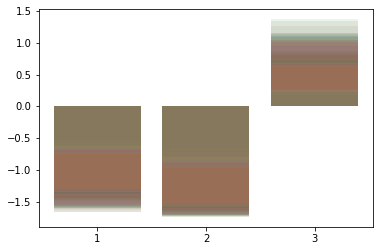

In [102]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import layers, losses

class AnomalyDetector(Model):
    
  def __init__(self,InputSize):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Dense(64, activation="relu"),
      layers.Dense(64, activation="relu"),
      layers.Dense(8, activation="relu"),
      layers.Dense(8, activation= "relu"),
      layers.Dense(3, activation = "selu"),
    ])
    

    self.decoder = tf.keras.Sequential([
      layers.Dense(8, activation="relu"),
      layers.Dense(8, activation="relu"),
      layers.Dense(64, activation="relu"),
      layers.Dense(64, activation="relu"),
      layers.Dense(InputSize, activation="linear")])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

def fun(InputSize, loss_fun = "mse"):
    
    AE =  AnomalyDetector(InputSize)
    AE.compile(loss=loss_fun,
               optimizer='adam'
              )
    return AE

### Path files
names = ['fan']
stati = ['normal', 'abnormal']
SNR = ['+6dB', '-6dB']

folder = '/MIMII/RawData/' + SNR[0] + '/' # fan/id_00/abnormal'
user_path = 'C:/Users/carbo/Documents/'
writer_path = 'C:/Users/carbo/Documents/MIMII/Data/' + SNR[0] +'/PSD/'

### Parameters
#IDs = ['id_00','id_02', 'id_04', 'id_06']

IDs = ['id_00']

AUCs = []

latent_space = []

for ID in IDs:

    # Get data
    #ID = IDs[2]
    status = stati[0] # normal
    name = names[0]
    data_path = folder + name + '/' + ID + '/' + status
    df_PSD_normal = PSD_DF_Maker(user_path, data_path)

    status = stati[1] # abnormal
    data_path = folder + name + '/' + ID + '/' + status
    df_PSD_abnormal = PSD_DF_Maker(user_path, data_path)

    # Create datasets for training/evaluation
    train_set, test_set, test_labels = Train_test_sets_maker.fun(df_PSD_normal,df_PSD_abnormal)
    # Normalize
    MIN,MAX = MinMaxNormalisation.getMinMax(train_set)
    train_set = MinMaxNormalisation.fun(train_set,MIN,MAX)
    test_set = MinMaxNormalisation.fun(test_set,MIN,MAX)


    # Train algorithm
    autoencoder = fun(train_set.shape[1])
    history = autoencoder.fit(train_set, train_set, 
                              epochs=50, 
                              batch_size=512,
                              validation_data=(test_set,test_set),
                              validation_split = 0.1,
                              verbose = 1,
                              shuffle=True
                             )
    
    lossValues = lossCalcMSE(autoencoder, test_set)
    AUCs.append(metrics.roc_auc_score(~test_labels, lossValues))      
    
tf_test_set = tf.cast(test_set,float)
encoded_data = autoencoder.encoder(tf_test_set,192).numpy()
feature_name = ['1','2','3']
for data in encoded_data:
    plt.bar(feature_name, data, alpha=0.1)
plt.show

In [103]:
AUCs

[0.9550253850008149]

In [107]:
df = pd.DataFrame(encoded_data)

In [108]:
matrix = df.corr(
    method = 'pearson',  # The method of correlation
    min_periods = 1      # Min number of observations required
)

In [109]:
matrix

,0,1,2
0,1.000000,0.997083,-0.981335
1,0.997083,1.000000,-0.965026
2,-0.981335,-0.965026,1.000000


Based on the analysis : the 3 latent space dimension are correlated. We can deduce that only 1D Latent space is enough !

## Latent space correlation matrix

In [110]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import layers, losses

class AnomalyDetector(Model):
    
  def __init__(self,InputSize):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Dense(64, activation="relu"),
      layers.Dense(64, activation="relu"),
      layers.Dense(8, activation= "relu"),
      layers.Dense(8, activation = "relu"),
      layers.Dense(1, activation="relu"),
    ])
    

    self.decoder = tf.keras.Sequential([
      layers.Dense(8, activation= "relu"),
      layers.Dense(8, activation= "relu"),
      layers.Dense(64, activation="relu"),
      layers.Dense(64, activation="relu"),
      layers.Dense(InputSize, activation="linear")])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

def fun(InputSize, loss_fun = "mse"):
    
    AE =  AnomalyDetector(InputSize)
    AE.compile(loss=loss_fun,
               optimizer='adam'
              )
    return AE


### Path files
names = ['fan']
stati = ['normal', 'abnormal']
SNR = ['+6dB', '-6dB']

folder = '/MIMII/RawData/' + SNR[0] + '/' # fan/id_00/abnormal'
user_path = 'C:/Users/carbo/Documents/'
writer_path = 'C:/Users/carbo/Documents/MIMII/Data/' + SNR[0] +'/PSD/'

### Parameters
IDs = ['id_00','id_02', 'id_04', 'id_06']

AUCs = []

latent_space = []

for ID in IDs:

    # Get data
    #ID = IDs[2]
    status = stati[0] # normal
    name = names[0]
    data_path = folder + name + '/' + ID + '/' + status
    df_PSD_normal = PSD_DF_Maker(user_path, data_path)

    status = stati[1] # abnormal
    data_path = folder + name + '/' + ID + '/' + status
    df_PSD_abnormal = PSD_DF_Maker(user_path, data_path)

    # Create datasets for training/evaluation
    train_set, test_set, test_labels = Train_test_sets_maker.fun(df_PSD_normal,df_PSD_abnormal)
    # Normalize
    MIN,MAX = MinMaxNormalisation.getMinMax(train_set)
    train_set = MinMaxNormalisation.fun(train_set,MIN,MAX)
    test_set = MinMaxNormalisation.fun(test_set,MIN,MAX)


    # Train algorithm
    autoencoder = fun(train_set.shape[1])
    history = autoencoder.fit(train_set, train_set, 
                              epochs=50, 
                              batch_size=512,
                              validation_data=(test_set,test_set),
                              validation_split = 0.1,
                              verbose = 1,
                              shuffle=True
                             )
    
    lossValues = lossCalcMSE(autoencoder, test_set)
    AUCs.append(metrics.roc_auc_score(~test_labels, lossValues))      

Train & test sets created !
Epoch 1/50
2/2 [==============================] - 1s 164ms/step - loss: 0.0035 - val_loss: 0.0252
Epoch 2/50
2/2 [==============================] - 0s 24ms/step - loss: 0.0034 - val_loss: 0.0251
Epoch 3/50
2/2 [==============================] - 0s 25ms/step - loss: 0.0033 - val_loss: 0.0249
Epoch 4/50
2/2 [==============================] - 0s 28ms/step - loss: 0.0032 - val_loss: 0.0247
Epoch 5/50
2/2 [==============================] - 0s 23ms/step - loss: 0.0031 - val_loss: 0.0246
Epoch 6/50
2/2 [==============================] - 0s 24ms/step - loss: 0.0030 - val_loss: 0.0244
Epoch 7/50
2/2 [==============================] - 0s 24ms/step - loss: 0.0029 - val_loss: 0.0242
Epoch 8/50
2/2 [==============================] - 0s 24ms/step - loss: 0.0028 - val_loss: 0.0239
Epoch 9/50
2/2 [==============================] - 0s 26ms/step - loss: 0.0027 - val_loss: 0.0237
Epoch 10/50
2/2 [==============================] - 0s 26ms/step - loss: 0.0025 - val_loss: 0.0235


In [111]:
AUCs

[0.9535101328713123, 0.8606233657404894, 0.9855330955212048, 1.0]

Pour autant sur certain dataset où la frontière Normale/Anormale est claire, l'autoencoder permet de bien séparer les données avec seulement un latent space de 1D. Mais lorsqu'il est plus compliqué de séparer, on observe une baisse des performances locales.

Conclusion : si la distinction est marquée, avoir une réduction du latent space peut amener à de meileurs résultats. Au contraire si elle est plus floue, le latent space peut ne pas être capable d'efficacement détecter le problème.

## Work on Id_02 : quel devrait-être le latent space dimension pour avoir des propriétés générales performantes ?


Train & test sets created !
Epoch 1/50
2/2 [==============================] - 1s 155ms/step - loss: 0.0088 - val_loss: 0.0135
Epoch 2/50
2/2 [==============================] - 0s 24ms/step - loss: 0.0086 - val_loss: 0.0133
Epoch 3/50
2/2 [==============================] - 0s 27ms/step - loss: 0.0084 - val_loss: 0.0131
Epoch 4/50
2/2 [==============================] - 0s 29ms/step - loss: 0.0083 - val_loss: 0.0130
Epoch 5/50
2/2 [==============================] - 0s 29ms/step - loss: 0.0081 - val_loss: 0.0128
Epoch 6/50
2/2 [==============================] - 0s 29ms/step - loss: 0.0080 - val_loss: 0.0126
Epoch 7/50
2/2 [==============================] - 0s 25ms/step - loss: 0.0079 - val_loss: 0.0124
Epoch 8/50
2/2 [==============================] - 0s 26ms/step - loss: 0.0077 - val_loss: 0.0123
Epoch 9/50
2/2 [==============================] - 0s 28ms/step - loss: 0.0076 - val_loss: 0.0121
Epoch 10/50
2/2 [==============================] - 0s 26ms/step - loss: 0.0075 - val_loss: 0.0120


<function matplotlib.pyplot.show(close=None, block=None)>

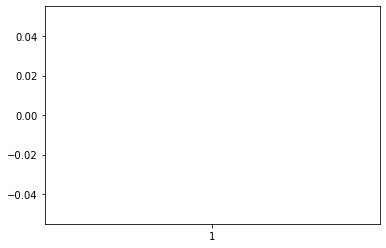

In [253]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import layers, losses

class AnomalyDetector(Model):
    
  def __init__(self,InputSize):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Dense(64, activation="relu"),
      layers.Dense(64, activation="relu"),
      layers.Dense(8, activation= "relu"),
      layers.Dense(8, activation = "relu"),
      layers.Dense(1, activation="relu"),
    ])
    

    self.decoder = tf.keras.Sequential([
      layers.Dense(8, activation= "relu"),
      layers.Dense(8, activation= "relu"),
      layers.Dense(64, activation="relu"),
      layers.Dense(64, activation="relu"),
      layers.Dense(InputSize, activation="linear")])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

def fun(InputSize, loss_fun = "mse"):
    
    AE =  AnomalyDetector(InputSize)
    AE.compile(loss=loss_fun,
               optimizer='adam'
              )
    return AE


### Path files
names = ['fan']
stati = ['normal', 'abnormal']
SNR = ['+6dB', '-6dB']

folder = '/MIMII/RawData/' + SNR[0] + '/' # fan/id_00/abnormal'
user_path = 'C:/Users/carbo/Documents/'
writer_path = 'C:/Users/carbo/Documents/MIMII/Data/' + SNR[0] +'/PSD/'

### Parameters
IDs = ['id_04']

AUCs = []

latent_space = []

for ID in IDs:

    # Get data
    #ID = IDs[2]
    status = stati[0] # normal
    name = names[0]
    data_path = folder + name + '/' + ID + '/' + status
    df_PSD_normal = PSD_DF_Maker(user_path, data_path)

    status = stati[1] # abnormal
    data_path = folder + name + '/' + ID + '/' + status
    df_PSD_abnormal = PSD_DF_Maker(user_path, data_path)

    # Create datasets for training/evaluation
    train_set, test_set, test_labels = Train_test_sets_maker.fun(df_PSD_normal,df_PSD_abnormal)
    # Normalize
    MIN,MAX = MinMaxNormalisation.getMinMax(train_set)
    train_set = MinMaxNormalisation.fun(train_set,MIN,MAX)
    test_set = MinMaxNormalisation.fun(test_set,MIN,MAX)


    # Train algorithm
    autoencoder = fun(train_set.shape[1])
    history = autoencoder.fit(train_set, train_set, 
                              epochs=50, 
                              batch_size=512,
                              validation_data=(test_set,test_set),
                              validation_split = 0.1,
                              verbose = 1,
                              shuffle=True
                             )
    
    lossValues = lossCalcMSE(autoencoder, test_set)
    AUCs.append(metrics.roc_auc_score(~test_labels, lossValues))  
    
tf_test_set = tf.cast(test_set,float)
encoded_data = autoencoder.encoder(tf_test_set,192).numpy()
feature_name = ['1']
for data in encoded_data:
    plt.bar(feature_name, data, alpha=0.1)
plt.show

In [254]:
AUCs

[0.8469992733518299]

In [ ]:
tf_PSD_normal = tf.cast(df_PSD_normal,float)
encoded_normal = autoencoder.encoder(tf_PSD_normal,192)

In [164]:
tf_PSD_normal = tf.cast(df_PSD_normal,float)
tf_PSD_abnormal = tf.cast(df_PSD_abnormal.iloc[:,:-1],float)

MIN,MAX = MinMaxNormalisation.getMinMax(tf_PSD_normal)
tf_PSD_normal = MinMaxNormalisation.fun(tf_PSD_normal,MIN,MAX)
tf_PSD_abnormal = MinMaxNormalisation.fun(tf_PSD_abnormal,MIN,MAX)

encoded_normal = autoencoder.encoder(tf_PSD_normal,192)
encoded_abnormal = autoencoder.encoder(tf_PSD_abnormal,192)

<function matplotlib.pyplot.show(close=None, block=None)>

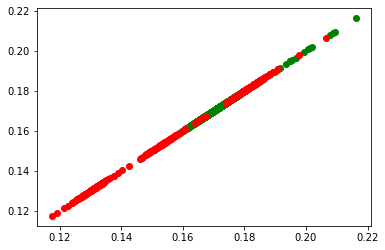

In [165]:
plt.scatter(encoded_normal,encoded_normal, color='green')
plt.scatter(encoded_abnormal,encoded_abnormal, color='red')
plt.show

## visualize reconstruction with different latent space dimensions

Train & test sets created !
Epoch 1/50
2/2 [==============================] - 1s 227ms/step - loss: 0.0038 - val_loss: 0.0274
Epoch 2/50
2/2 [==============================] - 0s 23ms/step - loss: 0.0036 - val_loss: 0.0272
Epoch 3/50
2/2 [==============================] - 0s 41ms/step - loss: 0.0035 - val_loss: 0.0269
Epoch 4/50
2/2 [==============================] - 0s 27ms/step - loss: 0.0034 - val_loss: 0.0266
Epoch 5/50
2/2 [==============================] - 0s 30ms/step - loss: 0.0033 - val_loss: 0.0263
Epoch 6/50
2/2 [==============================] - 0s 27ms/step - loss: 0.0031 - val_loss: 0.0259
Epoch 7/50
2/2 [==============================] - 0s 25ms/step - loss: 0.0030 - val_loss: 0.0254
Epoch 8/50
2/2 [==============================] - 0s 25ms/step - loss: 0.0028 - val_loss: 0.0248
Epoch 9/50
2/2 [==============================] - 0s 27ms/step - loss: 0.0026 - val_loss: 0.0241
Epoch 10/50
2/2 [==============================] - 0s 23ms/step - loss: 0.0024 - val_loss: 0.0233


<function matplotlib.pyplot.show(close=None, block=None)>

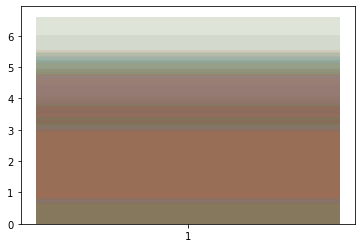

In [326]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import layers, losses

class AnomalyDetector(Model):
    
  def __init__(self,InputSize):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Dense(64, activation="relu"),
      layers.Dense(64,activation="relu"),
      layers.Dense(8, activation = "relu"),
      layers.Dense(1, activation="relu"),
    ])
    

    self.decoder = tf.keras.Sequential([
      layers.Dense(8, activation= "relu"),
      layers.Dense(64, activation="relu"),
      layers.Dense(64,activation="relu"),
      layers.Dense(InputSize, activation="linear")])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

def fun(InputSize, loss_fun = "mse"):
    
    AE =  AnomalyDetector(InputSize)
    AE.compile(loss=loss_fun,
               optimizer='adam'
              )
    return AE


### Path files
names = ['fan']
stati = ['normal', 'abnormal']
SNR = ['+6dB', '-6dB']

folder = '/MIMII/RawData/' + SNR[0] + '/' # fan/id_00/abnormal'
user_path = 'C:/Users/carbo/Documents/'
writer_path = 'C:/Users/carbo/Documents/MIMII/Data/' + SNR[0] +'/PSD/'

### Parameters
IDs = ['id_00']

AUCs = []

latent_space = []

for ID in IDs:

    # Get data
    #ID = IDs[2]
    status = stati[0] # normal
    name = names[0]
    data_path = folder + name + '/' + ID + '/' + status
    df_PSD_normal = PSD_DF_Maker(user_path, data_path)

    status = stati[1] # abnormal
    data_path = folder + name + '/' + ID + '/' + status
    df_PSD_abnormal = PSD_DF_Maker(user_path, data_path)

    # Create datasets for training/evaluation
    train_set, test_set, test_labels = Train_test_sets_maker.fun(df_PSD_normal,df_PSD_abnormal)
    # Normalize
    MIN,MAX = MinMaxNormalisation.getMinMax(train_set)
    train_set = MinMaxNormalisation.fun(train_set,MIN,MAX)
    test_set = MinMaxNormalisation.fun(test_set,MIN,MAX)


    # Train algorithm
    autoencoder = fun(train_set.shape[1])
    history = autoencoder.fit(train_set, train_set, 
                              epochs=50, 
                              batch_size=512,
                              validation_data=(test_set,test_set),
                              validation_split = 0.1,
                              verbose = 1,
                              shuffle=True
                             )
    
    lossValues = lossCalcMSE(autoencoder, test_set)
    AUCs.append(metrics.roc_auc_score(~test_labels, lossValues))  
    
tf_test_set = tf.cast(test_set,float)
encoded_data = autoencoder.encoder(tf_test_set,192).numpy()
feature_name = ['1']
for data in encoded_data:
    plt.bar(feature_name, data, alpha=0.1)
plt.show

In [327]:
AUCs

[0.9536067226484917]

<function matplotlib.pyplot.show(close=None, block=None)>

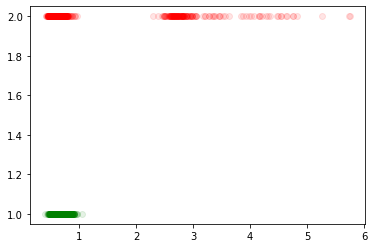

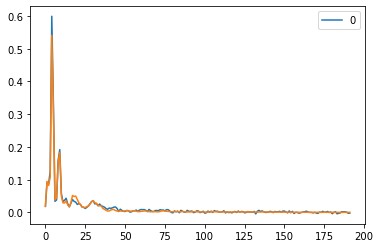

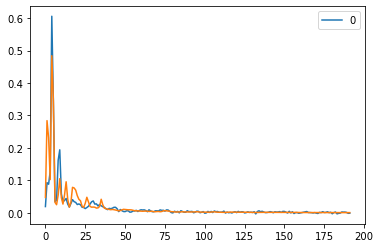

In [328]:
tf_PSD_normal = tf.cast(df_PSD_normal,float)
tf_PSD_abnormal = tf.cast(df_PSD_abnormal.iloc[:,:-1],float)

MIN,MAX = MinMaxNormalisation.getMinMax(tf_PSD_normal)
tf_PSD_normal = MinMaxNormalisation.fun(tf_PSD_normal,MIN,MAX)
tf_PSD_abnormal = MinMaxNormalisation.fun(tf_PSD_abnormal,MIN,MAX)

encoded_normal = autoencoder.encoder(tf_PSD_normal,192)
encoded_abnormal = autoencoder.encoder(tf_PSD_abnormal,192)

y_vec_normal = [1]*len(encoded_normal)
y_vec_abnormal = [2]*len(encoded_abnormal)
plt.scatter(encoded_normal,y_vec_normal, color='green',alpha=0.1)
plt.scatter(encoded_abnormal,y_vec_abnormal, color='red',alpha=0.1)
plt.show

#### Multiple plots
ID_to_test = 340


decoded_data = autoencoder.decoder(encoded_normal[ID_to_test])
df_data = pd.DataFrame(decoded_data).transpose()

df_data.plot()
plt.plot(tf_PSD_normal[ID_to_test,:])
plt.show

#### Multiple plots


decoded_data = autoencoder.decoder(encoded_abnormal[ID_to_test])
df_data = pd.DataFrame(decoded_data).transpose()

df_data.plot()
plt.plot(tf_PSD_abnormal[ID_to_test,:])
plt.show

## Visualisation of the reconstruction

- Utiliser le decoder 

- Sur chaque fréquence prendre la valeur moyenne et voir que tu peux mieux détecter qu'avec simplement un threshold.
- Feature-based : MSE signal et recherche de threshold -> Pour comparer avec AE

PSD / spectro : comparison entre les perf ventilateurs et vannes.

## Implementation of the Mahlanobis distance insteand of MSE